In [42]:
import json
import base64
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from glob import glob
from PIL import Image
from typing import Callable

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import nn, Tensor, optim
from torchvision import transforms
from torchvision.transforms import Compose, ToTensor, functional
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

print(f'torch: {torch.__version__}, torchvision: {torchvision.__version__}')import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from glob import glob

import torch
import torchvision
import torch.distributed as dist
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from collections import defaultdict, deque

In [43]:
def convert_annotations(input_path: os.PathLike, mode: str):
    results = []
    for file in sorted(glob(f'{input_path}/*.json'))[:5000]:  # [:5000] 삭제
        boxes = []
        labels = []
        with open(file, 'r') as f:
            annots = json.load(f)
            image = BytesIO(base64.b64decode(annots['imageData']))
            
            if mode == 'test':
                results.append({'file_name': annots['file_name'], 'image': image})
                continue
            
            for annot in annots['shapes']:
                box = np.array(annot['points'])
                x1, y1, x2, y2 = \
                    min(box[:, 0]), min(box[:, 1]), max(box[:, 0]), max(box[:, 1])
                boxes.append([x1, y1, x2, y2])
                labels.append(annot['label'])

            results.append({
                'image': image,
                'boxes': boxes,
                'labels': labels
            })
    return results

In [30]:
class LesionDataset(Dataset):
    def __init__(self, mode: str, input_path: os.PathLike, transforms: Callable = None):
        self.mode = mode
        self.data = convert_annotations(input_path, mode)
        self.transforms = transforms
        self.categories = {
            '01_ulcer': 1,
            '02_mass': 2,
            '04_lymph': 3,
            '05_bleeding': 4
        }
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        image = self.data[index]['image']
        image = Image.open(image).convert('RGB')
        
        if self.transforms is not None:
            image = self.transforms(image)

        if self.mode == 'test':
            file_name = self.data[index]['file_name']
            return image, file_name
        
        boxes = self.data[index]['boxes']
        labels = [self.categories[label] for label in self.data[index]['labels']]
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64)
        }

        return image, target

100%|██████████| 20874/20874 [00:03<00:00, 6552.72it/s]


In [31]:
train_tranforms = Compose([
    ToTensor()
])

def collate_fn(batch):
    return tuple(zip(*batch))


trainset= LesionDataset('train', './data/train/', train_tranforms)
testset= LesionDataset('test', './data/test/', train_tranforms)
train_loader = DataLoader(trainset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(testset, batch_size=16, shuffle=False, collate_fn=collate_fn)

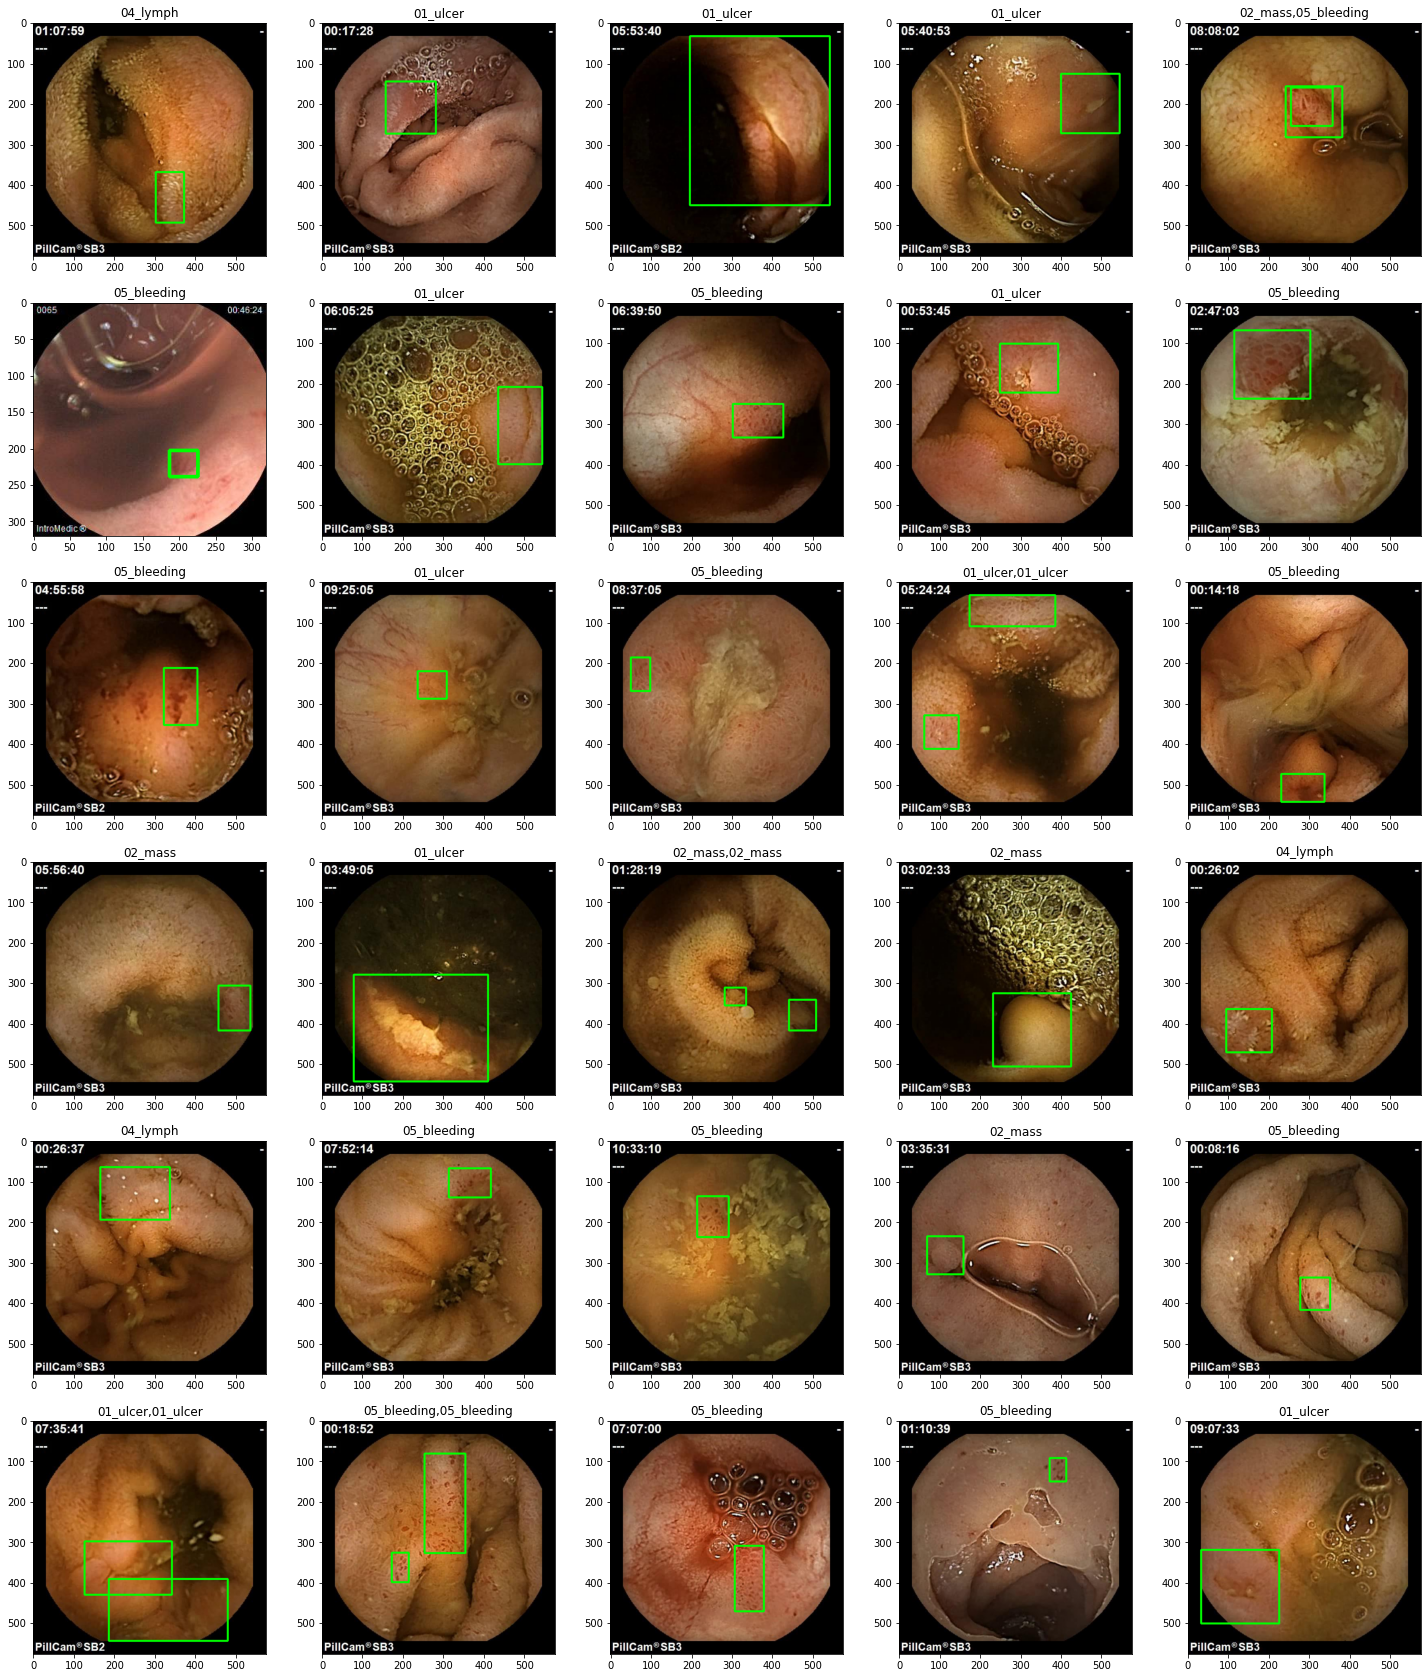

In [32]:
def show(images):
    if not isinstance(images, list):
        images = [images]

    fix, axes = plt.subplots(ncols=len(images), squeeze=False, dpi=200)
    for i, image in enumerate(images):
        image = image.clone().detach()
        image = functional.to_pil_image(image)
        axes[0, i].imshow(np.asarray(image))
        axes[0, i].axis('off')


results = [draw_bounding_boxes(
    torch.as_tensor(trainset[i][0]*255, dtype=torch.uint8),
    trainset[i][1]['boxes'],
    colors=['blue', 'yellow', 'red', 'green'],
    width=5
) for i in range(5)]
show(results)

In [44]:
backbone = resnet_fpn_backbone('resnet101', pretrained=True)
model = FasterRCNN(
    backbone,
    num_classes=5, 
    min_size=256,
    max_size=256
).to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [45]:
model.train()
num_epochs = 4
for epoch in range(num_epochs):
    for i, (images, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        images = [image.to('cuda') for image in images]
        targets = [{k: v.to('cuda') for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1} - Total: {losses:.4f}, Classifier: {loss_dict["loss_classifier"]:.4f}, Regression: {loss_dict["loss_box_reg"]:.4f}')

In [46]:
results = {
    'file_name':[], 'class_id':[], 'confidence':[], 'point1_x':[], 'point1_y':[],
    'point2_x':[], 'point2_y':[], 'point3_x':[], 'point3_y':[], 'point4_x':[], 'point4_y':[]
}

model.eval()
for i, (image, file_names) in enumerate(test_loader):
    images = [image.to('cuda') for image in images]
    outputs = model(images)
    for file_name, output in zip(file_names, outputs):
        mask = output['scores'] > 0.3
        boxes = output['boxes'][mask].detach().cpu().numpy()
        scores = output['scores'][mask].detach().cpu().numpy()
        class_ids = output['labels'][mask].detach().cpu().numpy()
        for box, score, class_id in zip(boxes, scores, class_ids):
            x_min, y_min, x_max, y_max = box
            results['file_name'].append(file_name)
            results['class_id'].append(class_id)
            results['confidence'].append(score)
            results['point1_x'].append(x_min)
            results['point1_y'].append(y_min)
            results['point2_x'].append(x_max)
            results['point2_y'].append(y_min)
            results['point3_x'].append(x_max)
            results['point3_y'].append(y_max)
            results['point4_x'].append(x_min)
            results['point4_y'].append(y_max)

In [47]:
submission = pd.DataFrame(results)
submission.to_csv('submission.csv', index=False)
submission.head(10)